<a href="https://colab.research.google.com/github/SiravichMek/CSS485-Deep-Learning/blob/main/Deep_Learning_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Members:
* Siravich Jitpremvanich 6422782704
* Chawanakon Promsila 6422770246
* Woraseth Limwanich 6422782621

#Importing Libraries
> ## TensorFlow and Keras:
 * tensorflow and tensorflow.keras are imported to build and train neural network models.
 * The layers and models submodules from Keras are essential for defining the architecture of the model.

> ## Scikit-learn:
* Provides utilities for data preprocessing, model evaluation, and dataset splitting.

> ## NumPy and Pandas:
* Used for data manipulation and mathematical operations.

> ## Evaluation Metrics:
* Metrics like accuracy_score, f1_score, precision_score, and recall_score from sklearn.metrics are used to assess model performance.





In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

#Configuration Pandas display settings and Matplotlib plotting properties:

* Pandas:
> * Sets the maximum number of columns (100), rows (100), and column width (150 characters) to display.
* Matplotlib:
> * Adjusts the global font size to 16 and tick label sizes to 14 for both x and y axes.
> * Increases figure resolution by setting the DPI to 300 for high-quality plots.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 150)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rcParams['figure.dpi'] = 300

# Importing data of particle classification

In [ ]:
X = pd.read_csv('/content/Features_lim_2.csv')
y = np.genfromtxt('/content/Labels_lim_2.txt')
X.values.shape

(5000, 24)

# Splitting the dataset into training, validation, and test sets, and then standardizing the training data using StandardScaler.

In [ ]:
X_train = X.values[:3000,:]
y_train = y[:3000]

In [ ]:
X_val = X.values[3000:4000,:]
y_val = y[3000:4000]

In [ ]:
X_test = X.values[4000:,:]
y_test = y[4000:]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

# Model Building (Feed Forward Neural Network)

# 1. Data Preparation:
> * Standardized versions of datasets (Xst_train, Xst_val, Xst_test) are already created using scaler.transform().
> * Encodes labels into categorical format suitable for multi-class classification using tf.keras.utils.to_categorical.

# 2. Model Building Function:
> * Creates a Sequential model with a variable number of Dense layers, Batch Normalization, and Dropout layers.
> * Uses hyperparameters for tuning the number of layers, units in each layer, dropout rates, and learning rates.
> *	Compiles the model with Adam optimizer and binary cross-entropy loss.

# 3. Hyperparameter Tuning:
> *	Sets up Keras Tuner with Random Search to find the best hyperparameters for the model.
> * Configures early stopping and learning rate scheduler callbacks to avoid overfitting and adjust learning rates dynamically.

# 4. Model Training and Evaluation:
> * Performs hyperparameter search with tuner.search() and trains the best model found.
> * Evaluates the model on the test set and prints the test accuracy.
> * Generates predictions, converts them from one-hot encoding back to original labels, and computes performance metrics (accuracy, F1 score, precision, recall).
> *	Displays these metrics in a Pandas DataFrame.

In [ ]:
!pip install keras-tuner -q

In [ ]:
Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

In [ ]:
# Encode labels to categorical format
num_classes = len(np.unique(y_train))
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=(24,)))

    # Add a variable number of Dense layers with different units and dropout
    for i in range(hp.Int('num_layers', 1, 3)):  # Tune number of layers between 1 and 3
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=64, step=16), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float('dropout_' + str(i), 0.1, 0.5, step=0.1)))  # Tune dropout rate between 0.1 and 0.5

    # Output layer
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Instantiate the Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter configurations to try
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',
    project_name='particle_classification'
)

# Define early stopping and learning rate scheduler as callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Perform the hyperparameter search
tuner.search(Xst_train, y_train_encoded,
             epochs=50,
             batch_size=200,
             validation_data=(Xst_val, y_val_encoded),
             callbacks=[early_stopping, lr_scheduler])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(Xst_train, y_train_encoded,
                         epochs=100,
                         batch_size=200,
                         validation_data=(Xst_val, y_val_encoded),
                         callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(Xst_test, y_test_encoded)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate Predictions
y_pred_encoded = best_model.predict(Xst_test)

# Convert predictions and true values back from one-hot encoding to original labels
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Create a table with the metrics
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
})

# Display the metrics table
print(metrics_table)

# Save the best model
best_model.save('best_particle_classification_feedforward_model.h5')

Reloading Tuner from my_dir/particle_classification/tuner0.json
Best Hyperparameters: {'num_layers': 1, 'units_0': 64, 'dropout_0': 0.4, 'learning_rate': 0.001, 'units_1': 32, 'dropout_1': 0.5, 'units_2': 32, 'dropout_2': 0.1}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.4209 - loss: 1.4059 - val_accuracy: 0.5240 - val_loss: 1.0481 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5878 - loss: 1.1155 - val_accuracy: 0.7960 - val_loss: 0.9009 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7175 - loss: 0.9455 - val_accuracy: 0.8740 - val_loss: 0.7919 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7699 - loss: 0.8435 - val_accuracy: 0.9100 - val_loss: 0.7115 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8265 - loss: 0.7512 - val_accuracy: 0.9240 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8476 - loss: 0.6927 - val_accuracy: 0.9270 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8822 - loss: 0.6218 - 

      Metric     Score
0   Accuracy  0.941000
1   F1 Score  0.937355
2  Precision  0.939736
3     Recall  0.941000


# Visualization Model's Peformance (Feed Forward Neural Network)

The training and validation loss, as well as accuracy, were plotted to visualize the model's performance:

- Training Loss vs. Validation Loss: Both losses decreased over time, with the validation loss stabilizing, indicating that the model is not overfitting.
- Training Accuracy vs. Validation Accuracy: The training accuracy steadily increased, and the validation accuracy followed a similar trend, showing that the model generalizes well.


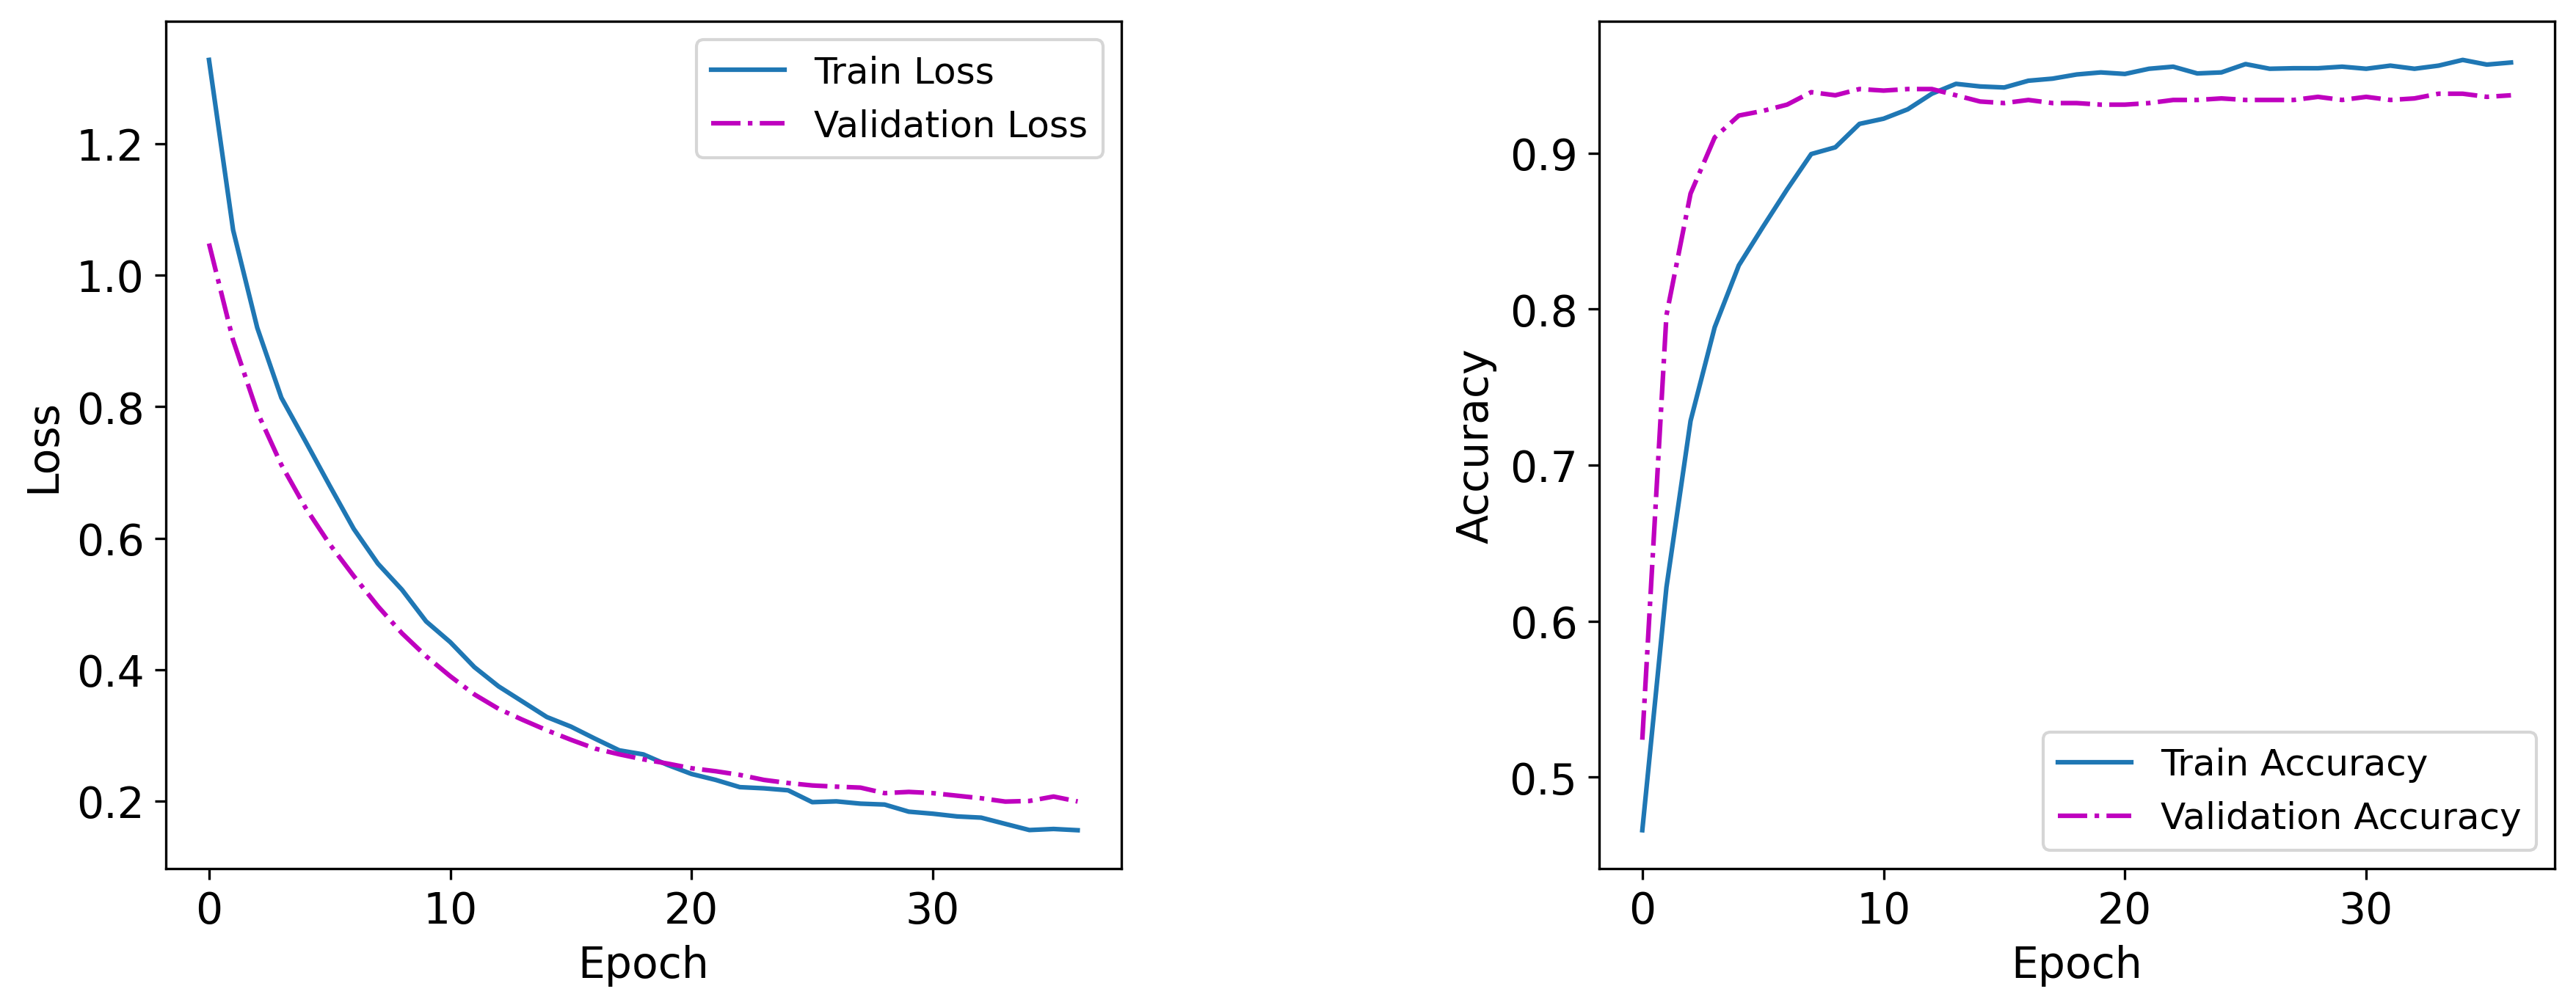

In [ ]:
# Access the training history from the history object
history_dict = history.history

# Create a figure for loss and accuracy
plt.figure(figsize=(14,5))

# Plot the loss
plt.subplot(121)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], '-.m', label='Validation Loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# Plot the accuracy
plt.subplot(122)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], '-.m', label='Validation Accuracy')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5)

# Save the plot or show it
# plt.savefig('RegularizedNN.png', dpi=300)
plt.show()


# Model Building (LSTM)

# 1. Data Preparation:
> * Standardized versions of datasets (Xst_train, Xst_val, Xst_test) are already created using scaler.transform().
> * Encodes labels into categorical format suitable for multi-class classification using tf.keras.utils.to_categorical.

# 2. Reshaping Input Data:
> * Reshapes the standardized input data (`Xst_train`, `Xst_val`, `Xst_test`) to fit the LSTM input requirements, with dimensions `(24, 1)`.

# 3. Model Definition:
> * **LSTM Layer**: Adds an LSTM layer with 64 units to handle sequence data.
> * **Dropout Layers**: Includes dropout layers with a 30% dropout rate to prevent overfitting.
> * **Dense Layers**: Adds a dense layer with 32 units and ReLU activation, followed by batch normalization.
> * **Output Layer**: Uses a dense layer with a `sigmoid` activation function for multi-class classification.

# 4. Model Compilation:
> * Compiles the model using the Adam optimizer with a learning rate of 0.001 and `binary_crossentropy` loss.

# 5. Callbacks:
> * **EarlyStopping**: Stops training if validation loss does not improve for 3 epochs, restoring the best model weights.
> * **ReduceLROnPlateau**: Reduces the learning rate by 50% if validation loss plateaus for 3 epochs.

# 6. Model Training:
> * Trains the model with the reshaped training data and encoded labels for up to 100 epochs, using early stopping and learning rate adjustment.

# 7. Model Evaluation:
> * Evaluates the model on the test set to determine its accuracy and loss.
> * Generates predictions, converts them from one-hot encoding, and calculates performance metrics (accuracy, F1 score, precision



In [ ]:
Xst_train = scaler.transform(X_train)
Xst_val = scaler.transform(X_val)
Xst_test = scaler.transform(X_test)

In [ ]:
Xst_train = Xst_train.reshape((Xst_train.shape[0], 24, 1))
Xst_val = Xst_val.reshape((Xst_val.shape[0], 24, 1))
Xst_test = Xst_test.reshape((Xst_test.shape[0], 24, 1))

# Encode labels to categorical format
num_classes = len(np.unique(y_train))
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

# Define the LSTM model
model = models.Sequential()

# LSTM layer
model.add(layers.LSTM(units=64, input_shape=(24, 1), return_sequences=False))

# Dropout after LSTM layer
model.add(layers.Dropout(0.3))

# Dense layers
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.BatchNormalization())

# Dropout after dense layer
model.add(layers.Dropout(0.3))

# Output layer
model.add(layers.Dense(num_classes, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping and learning rate scheduler as callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(Xst_train, y_train_encoded,
                    epochs=100,
                    batch_size=200,
                    validation_data=(Xst_val, y_val_encoded),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(Xst_test, y_test_encoded)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate Predictions
y_pred_encoded = model.predict(Xst_test)

# Convert predictions and true values back from one-hot encoding to original labels
y_pred = np.argmax(y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate accuracy, F1 score, precision, and recall
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Create a table with the metrics
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1, precision, recall]
})

# Display the metrics table
print(metrics_table)

# Save the model
model.save('particle_classification_lstm_model.h5')


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.6704 - loss: 0.6697 - val_accuracy: 0.8530 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.8558 - loss: 0.4934 - val_accuracy: 0.9140 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8925 - loss: 0.4290 - val_accuracy: 0.9120 - val_loss: 0.5719 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8975 - loss: 0.3994 - val_accuracy: 0.9000 - val_loss: 0.5464 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9019 - loss: 0.3907 - val_accuracy: 0.9060 - val_loss: 0.5103 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9061 - loss: 0.3823 - val_accuracy: 0.8960 - val_loss: 0.4883 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9126 - loss: 0.3365 - val_accu

      Metric     Score
0   Accuracy  0.937000
1   F1 Score  0.937732
2  Precision  0.938710
3     Recall  0.937000


In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(Xst_test, y_test_encoded, verbose=1)

# Print the accuracy in percentage format
print("Accuracy of LSTM: %.2f%%" % (scores[1] * 100))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9407 - loss: 0.1663
Accuracy of LSTM: 93.70%


# Visualization Model's Peformance (LSTM)

To better understand how the LSTM model performed during training, we plotted both the training and validation loss as well as the training and validation accuracy over the epochs.

**Loss Plot**

The plot shows the training loss decreasing consistently over time, indicating that the model is learning effectively. The validation loss initially decreases but starts to stabilize, suggesting that the model is not overfitting. This is further supported by the use of early stopping, which ensures that training halts when no further improvement in validation loss is observed.

**Accuracy Plot**

The training accuracy steadily increases with each epoch, as expected, while the validation accuracy follows a similar trend, confirming that the model generalizes well to unseen data. The validation accuracy stabilizes at around 94%, demonstrating that the model is well-tuned for the particle classification task.

The following graphs provide a visual representation of the LSTM model’s performance:

Left Plot (Loss): Shows the comparison between

*   Left Plot (Loss): Shows the comparison between training and validation loss.
*   Right Plot (Accuracy): Displays the training accuracy alongside validation accuracy over epochs.



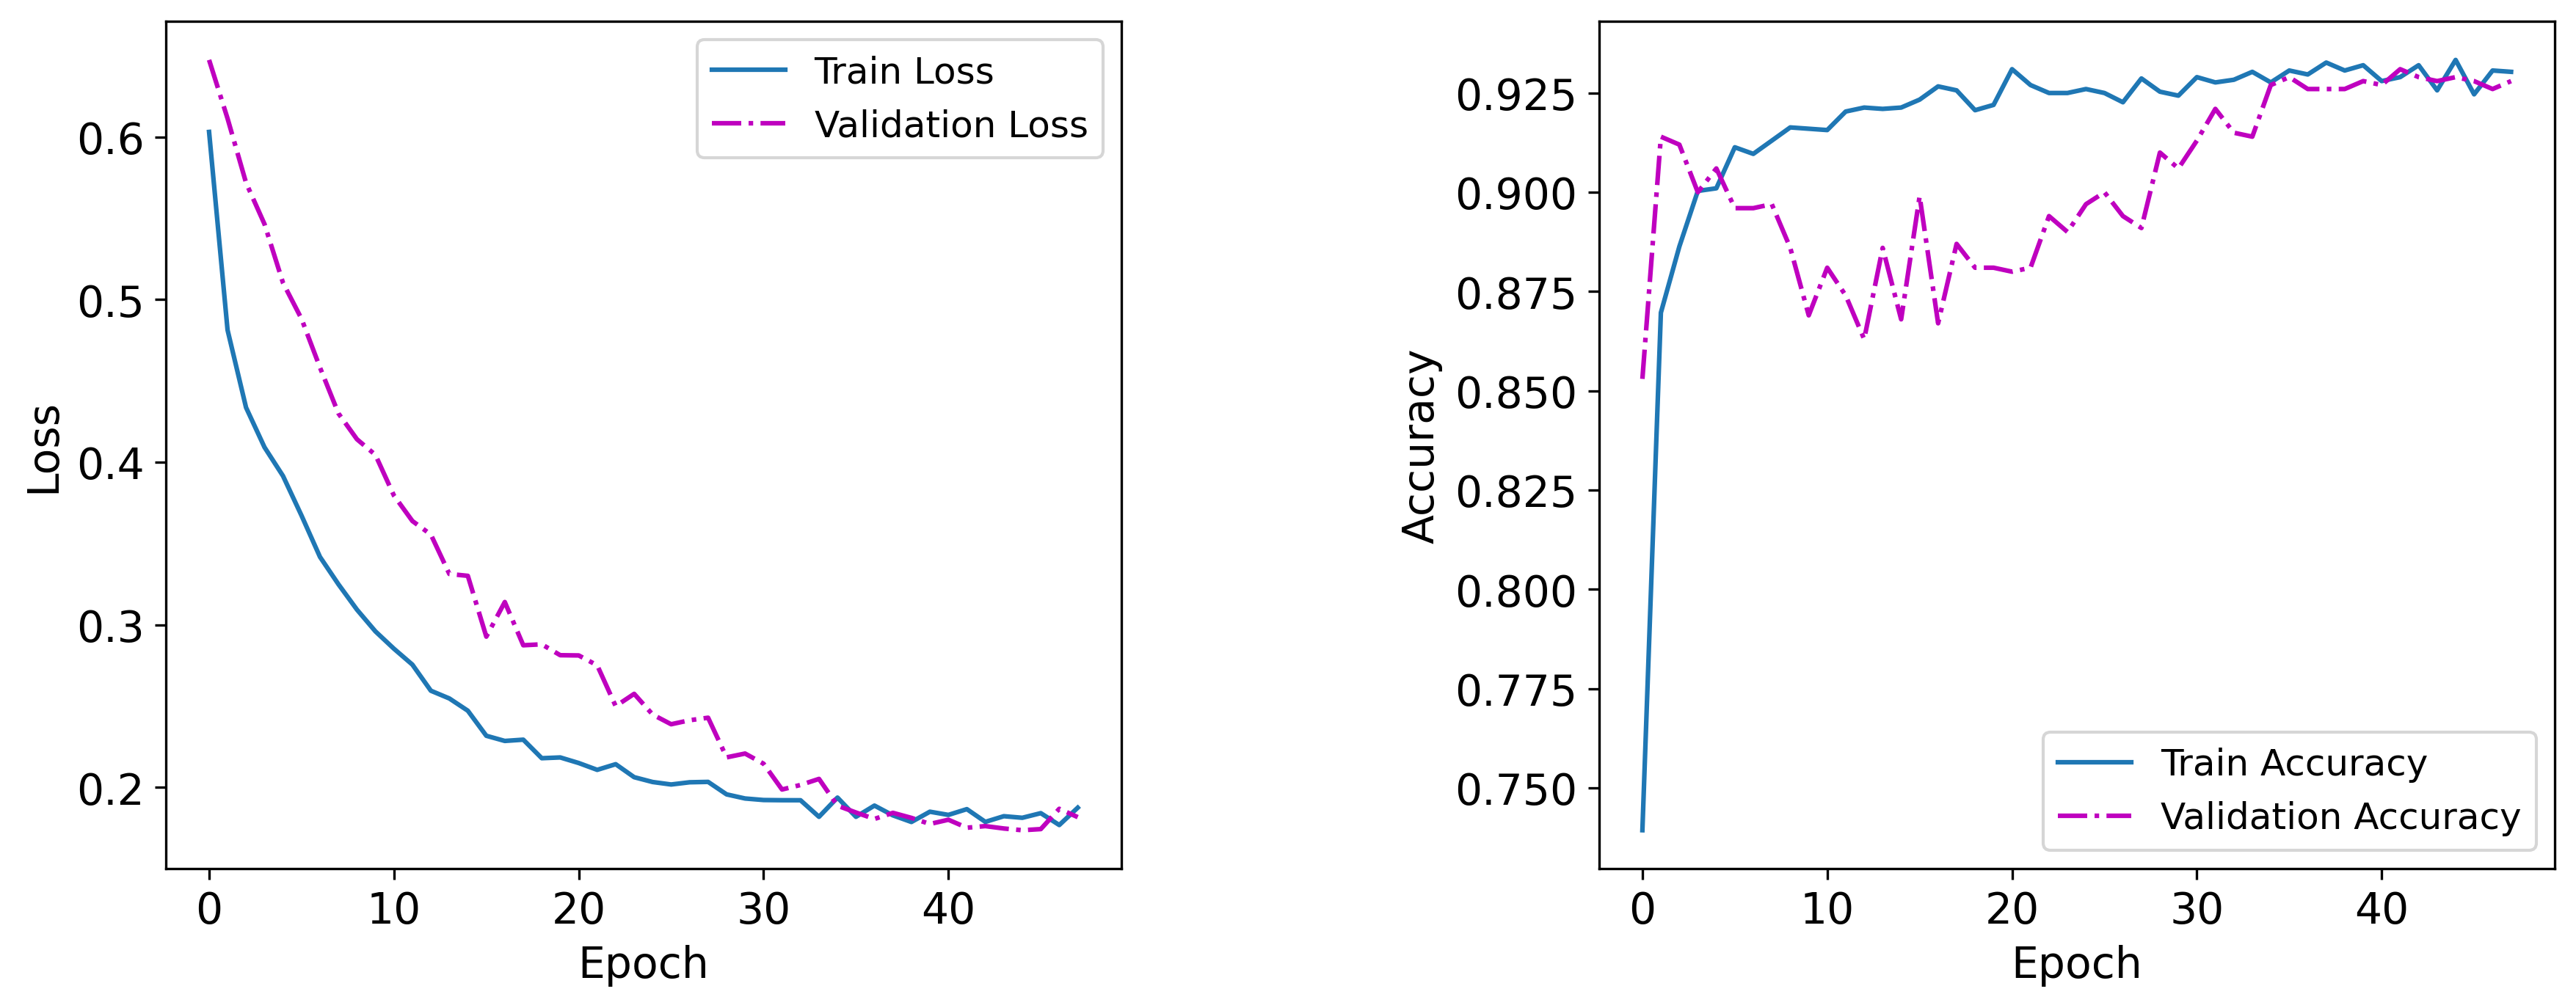

In [ ]:
# Access the training history from the history object
history_dict = history.history

# Create a figure for loss and accuracy
plt.figure(figsize=(14,5))

# Plot the loss
plt.subplot(121)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], '-.m', label='Validation Loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# Plot the accuracy
plt.subplot(122)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], '-.m', label='Validation Accuracy')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5)

# Save the plot or show it
# plt.savefig('RegularizedNN.png', dpi=300)
plt.show()


# Comparison Performace of Feed Forward Model and LSTM Model

The Feed Forward Neural Network (FFNN) and Long Short-Term Memory (LSTM) models were evaluated using the same test dataset to compare their performance in terms of accuracy, F1 score, precision, and recall. The results for both models are summarized in the following table:

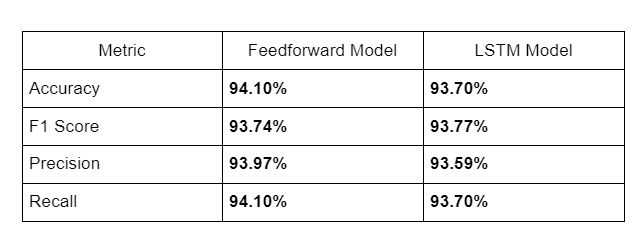

**Performance Visualization**

The following bar chart visually compares the performance of the two models across the four key metrics. As shown, the FFNN outperforms the LSTM in all aspects by a narrow margin.



*   **Accuracy**: Both models achieved high accuracy, with the FFNN performing slightly better at 94.10%.
*   **F1 Score**: The LSTM has a marginally higher F1 score (93.77%) than the LSTM (93.74%), indicating a slight improvement in the balance between precision and recall.
*   **Precision and Recall**: Both models achieved strong precision and recall scores, with the FFNN maintaining a small advantage in both metrics.

This comparison illustrates that while both models performed well in classifying the particles, the FFNN slightly outperformed the LSTM in every evaluated metric. The chart provides a clear visual confirmation of these results, showing the FFNN's consistent, albeit small, advantage.






32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


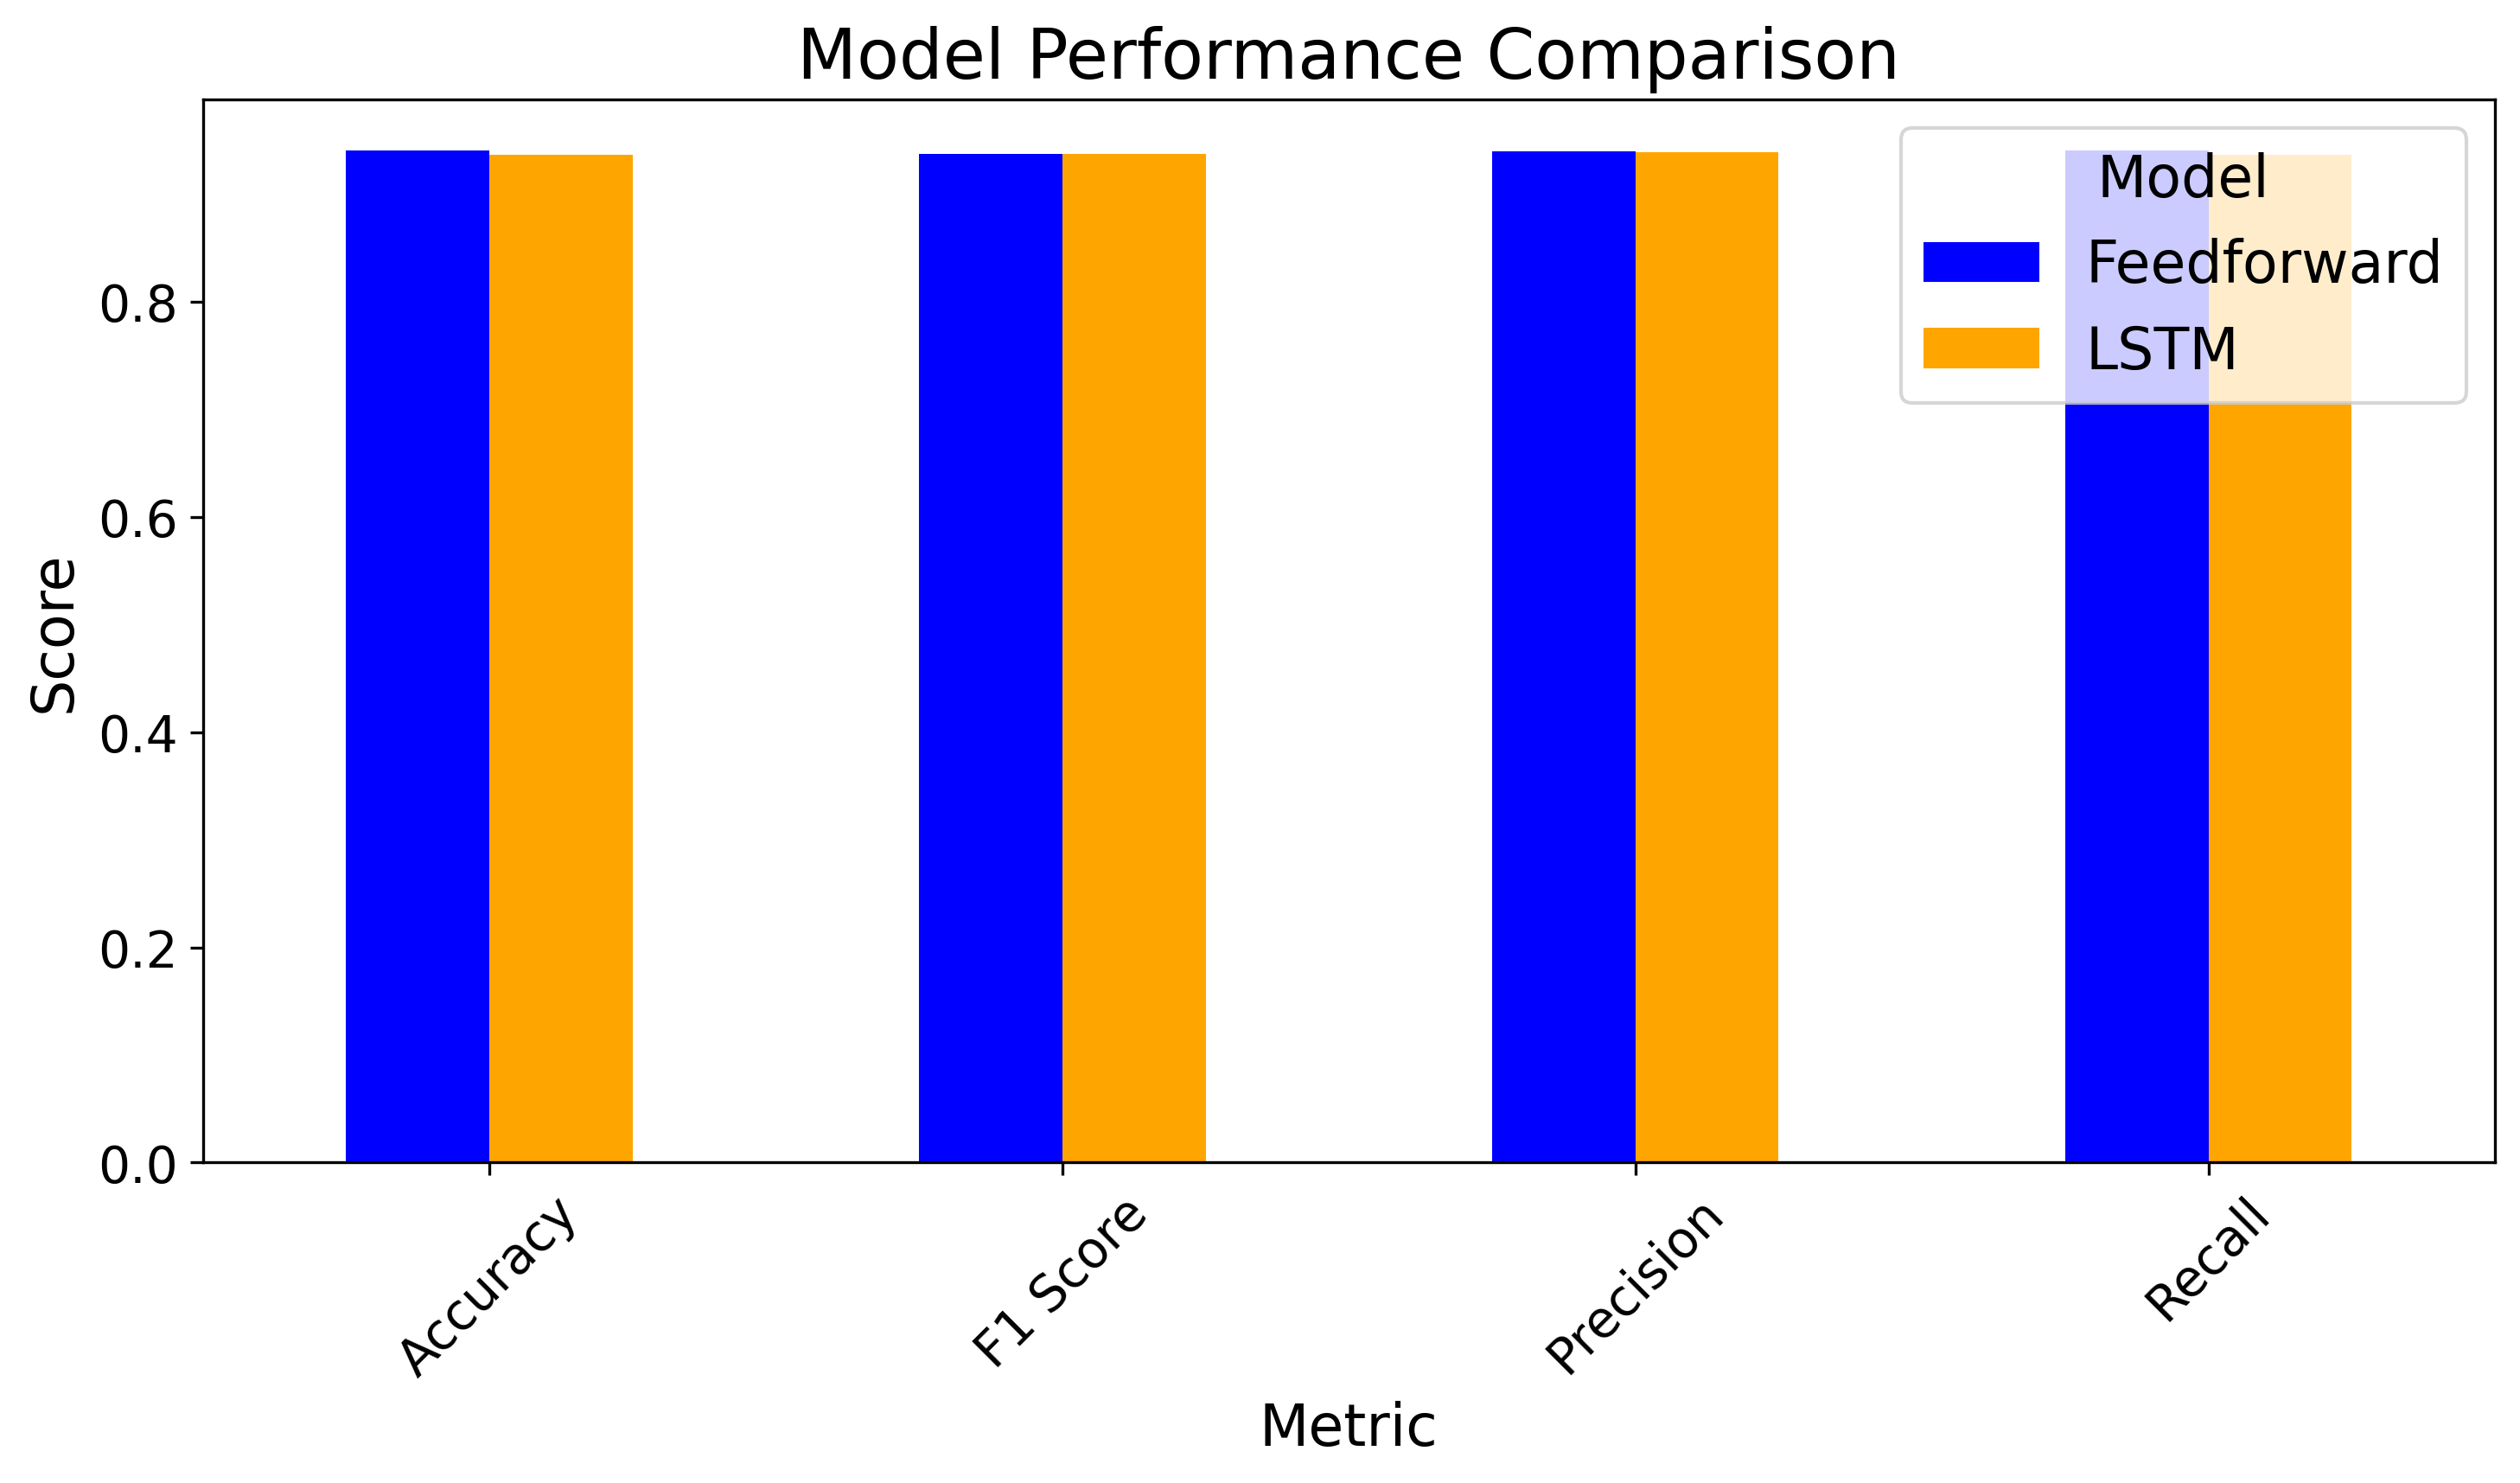

In [ ]:
# Load the saved models
feedforward_model = tf.keras.models.load_model('best_particle_classification_feedforward_model.h5')
lstm_model = tf.keras.models.load_model('particle_classification_lstm_model.h5')

# Evaluate both models on the test set
feedforward_test_loss, feedforward_test_acc = feedforward_model.evaluate(Xst_test, y_test_encoded, verbose=0)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(Xst_test, y_test_encoded, verbose=0)

# Generate predictions for both models
feedforward_y_pred_encoded = feedforward_model.predict(Xst_test)
lstm_y_pred_encoded = lstm_model.predict(Xst_test)

# Convert predictions and true values back from one-hot encoding to original labels
feedforward_y_pred = np.argmax(feedforward_y_pred_encoded, axis=1)
lstm_y_pred = np.argmax(lstm_y_pred_encoded, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate accuracy, F1 score, precision, and recall for both models
feedforward_accuracy = accuracy_score(y_true, feedforward_y_pred)
feedforward_f1 = f1_score(y_true, feedforward_y_pred, average='weighted')
feedforward_precision = precision_score(y_true, feedforward_y_pred, average='weighted')
feedforward_recall = recall_score(y_true, feedforward_y_pred, average='weighted')

lstm_accuracy = accuracy_score(y_true, lstm_y_pred)
lstm_f1 = f1_score(y_true, lstm_y_pred, average='weighted')
lstm_precision = precision_score(y_true, lstm_y_pred, average='weighted')
lstm_recall = recall_score(y_true, lstm_y_pred, average='weighted')

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Feedforward': [feedforward_accuracy, feedforward_f1, feedforward_precision, feedforward_recall],
    'LSTM': [lstm_accuracy, lstm_f1, lstm_precision, lstm_recall]
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

metrics_df.set_index('Metric').plot(kind='bar', ax=ax, color=['blue', 'orange'])
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.set_xlabel('Metric')
ax.legend(title='Model')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
